# Load Datasets

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

from wordcloud import WordCloud
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff

## IndoNLU Dataset

In [3]:
df_indonlu_test = pd.read_csv("/content/drive/MyDrive/FD-WAVE-11/Platinum-challange/test_preprocess.tsv", sep='\t', header= None)
df_indonlu_train = pd.read_csv("/content/drive/MyDrive/FD-WAVE-11/Platinum-challange/train_preprocess.tsv", sep='\t', header= None)
df_indonlu_valid = pd.read_csv("/content/drive/MyDrive/FD-WAVE-11/Platinum-challange/valid_preprocess.tsv", sep='\t', header= None)

df_indonlu = df_indonlu_train.append(df_indonlu_test, ignore_index=True)
df_indonlu = df_indonlu.append(df_indonlu_valid, ignore_index=True)
df_indonlu.columns = ['text','label']
df_indonlu.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
df_indonlu.label.value_counts()

positive    7359
negative    4034
neutral     1367
Name: label, dtype: int64

In [5]:
df_indonlu.shape

(12760, 2)

# Data Cleansing

In [6]:
print(df_indonlu.shape)

(12760, 2)


In [7]:
print(df_indonlu.columns)

Index(['text', 'label'], dtype='object')


In [8]:
df_final = df_indonlu.copy() #indonlu

df_final.shape

(12760, 2)

In [9]:
df_final = df_final.drop(df_final[df_final['label'] == 'neutral'].index)

In [10]:
df_final.label.value_counts()

positive    7359
negative    4034
Name: label, dtype: int64

# EDA

In [11]:
df_final.isnull().sum()

text     0
label    0
dtype: int64

In [12]:
sentiment_counts = df_final['label'].value_counts().sort_index()

sentiment_labels = ['positive', 'negative']
sentiment_colors = ['red', 'grey']

fig = go.Figure(data=[go.Pie(labels=sentiment_counts.index,
                             values=sentiment_counts.values,
                             textinfo='percent+value+label',
                             marker_colors=sentiment_colors,
                             textposition='auto',
                             hole=.3)])

fig.update_layout(
    title_text='Sentiment Distribution',
    template='plotly_white',
    xaxis=dict(
        title='Sources',
    ),
    yaxis=dict(
        title='Number of Posts in Twitter',
    )
)

fig.update_traces(marker_line_color='black',
                  marker_line_width=1.5,
                  opacity=0.8)

fig.show()

In [13]:
from nltk.stem import WordNetLemmatizer

def get_all_string(sentences):
    sentence = ''
    for words in sentences:
        sentence += words
    sentence = re.sub('[^A-Za-z0-9 ]+', '', sentence)
    sentence = re.sub(r'http\S+', '', sentence)
    print(sentence, type(sentence))
    sentence = sentence.lower()
    return sentence

def get_word(sentence):
    return nltk.RegexpTokenizer(r'\w+').tokenize(sentence)

def remove_stopword(word_tokens):
    stopword_list = set(stopwords.words('indonesian'))
    stopword_list.add("rt")
    stopword_list.add("user")
    stopword_list.add("yg")
    stopword_list.add("nya")
    stopword_list.add("ya")
    stopword_list.add("sih")
    filtered_tokens = []

    for word in word_tokens:
        if word not in stopword_list:
            filtered_tokens.append(word)
    return filtered_tokens

def lemmatize_words(filtered_tokens):
    lemm = WordNetLemmatizer()
    cleaned_tokens = [lemm.lemmatize(word) for word in filtered_tokens]
    return cleaned_tokens

def create_freq_df(cleaned_tokens):
    fdist = nltk.FreqDist(cleaned_tokens)
    freq_df = pd.DataFrame.from_dict(fdist, orient='index')
    freq_df.columns = ['Frequency']
    freq_df.index.name = 'Term'
    freq_df = freq_df.sort_values(by=['Frequency'], ascending=False)
    freq_df = freq_df.reset_index()
    return freq_df

def preprocess(series):
    all_string = get_all_string(series)
    words = get_word(all_string)
    filtered_tokens = remove_stopword(words)
    cleaned_tokens = lemmatize_words(filtered_tokens)
    return cleaned_tokens


def plot_text_distribution(x_df, y_df, color, title, xaxis_text, yaxis_text):
    fig = px.bar(x=x_df,
                y=y_df,
                color=y_df,
                text=y_df,
                color_continuous_scale=color)

    fig.update_layout(
        title_text=title,
        template='plotly_white',
        xaxis=dict(
            title=xaxis_text,
        ),
        yaxis=dict(
            title=yaxis_text,
        )
    )

    fig.update_traces(marker_line_color='black',
                    marker_line_width=1.5,
                    opacity=0.8)

    fig.show()

def create_wordcloud(freq_df, title, color):

    data = freq_df.set_index('Term').to_dict()['Frequency']

    plt.figure(figsize = (20,15))
    wc = WordCloud(width=800,
               height=400,
               max_words=100,
               colormap= color,
               max_font_size=200,
               min_font_size = 1 ,
               random_state=8888,
               background_color='white').generate_from_frequencies(data)

    plt.imshow(wc, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

In [14]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

positive_words = preprocess(df_final.loc[df_final['label'] == 'positive']['text'])
positive_words_df = create_freq_df(positive_words)
top10_positive_words = positive_words_df[:10]

plot_text_distribution(top10_positive_words['Term'], top10_positive_words['Frequency'],
                  'Greens', 'Top 10 Positive Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(positive_words_df, 'Positive Sentiment Text Distribution', 'BuGn')

Output hidden; open in https://colab.research.google.com to view.

duh  jadi mahasiswa jangan sombong dong  kasih kartu kuning segala  belajar dulu yang baik  tidak usahlah ikutikut politik  nanti sudah selesai kuliah nya mau ikut politik juga tidak telat  dasar mahasiswa pakai kartu kredit bca tidak untung malah rugi besarsimcard indosat inaktiv garagara lupa isi pulsa dan kabar nya aktif jika pinda ke pasca bayar  ribet bangetsifat iri sering muncul pada orang orang yang tidak punya tujuan hiduppengalaman bersama indosat hari ini  semoga tidak terjadi pada pelanggan lain  sempat sampai marahmarah dengan pelayanan pelanggan indosatanak sekarang sulit untuk dinasehatihanya mengatasi masalah kayak gini saja anies sandi tidak becus  ke mana saja pasukan kebersihan yang begitu banyak jumlah nya alhamdulillah hari ini tidak ke jalan bugel agak kesal juga kalau tiap hari lewat sana melulu  sempit  dua arah  macet sudah jadi makanan sehariharirespon agak lama  sama sayang nya rem nya bukan asli  masih rom distrobitormalu  maluin nih oknum yang tidak bertang

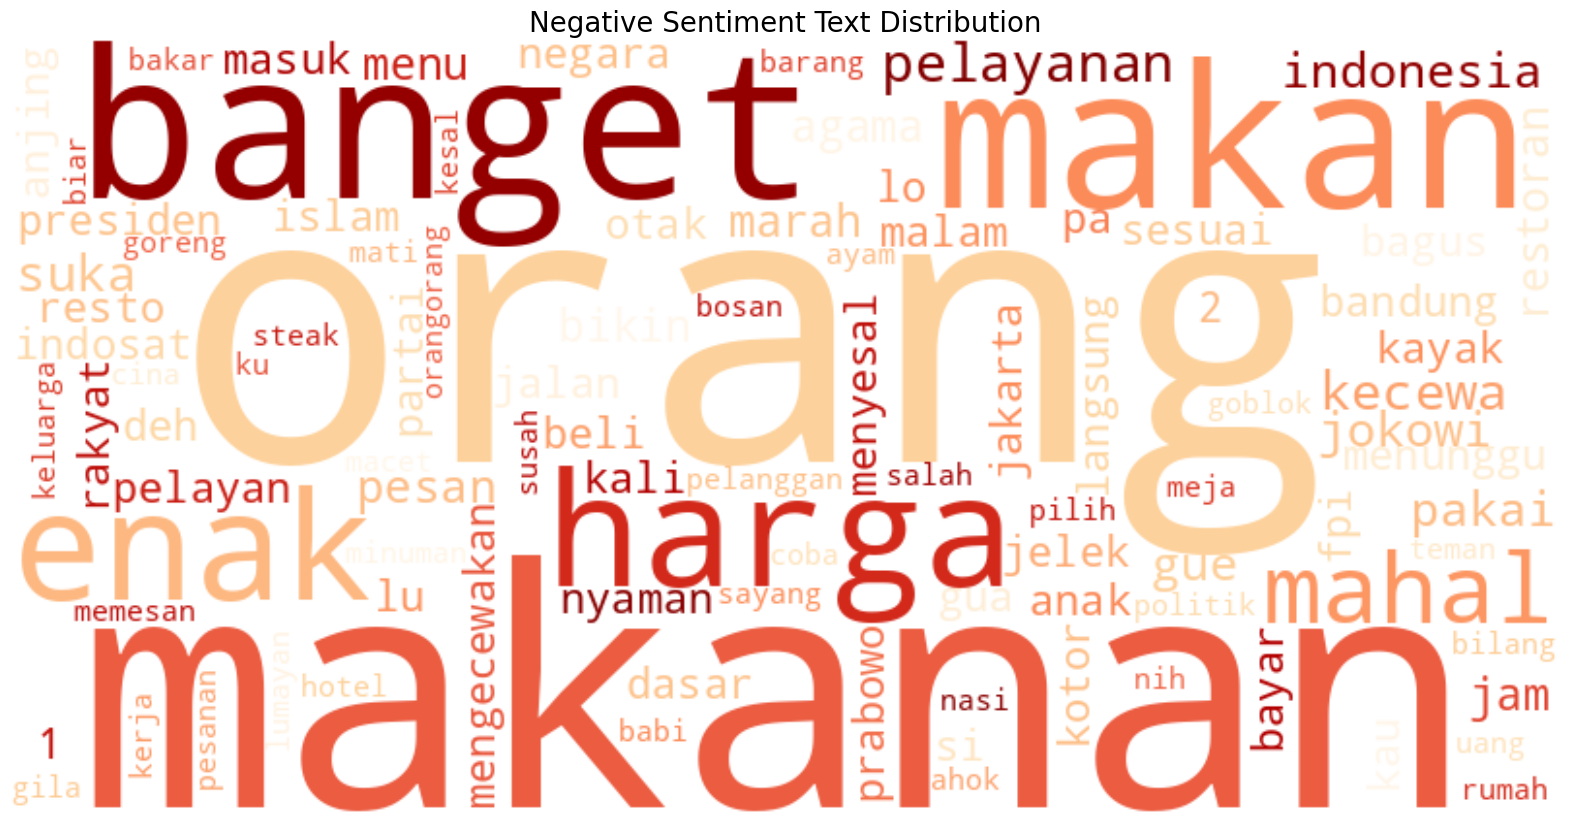

In [15]:
negative_words = preprocess(df_final.loc[df_final['label'] == 'negative']['text'])
negative_words_df = create_freq_df(negative_words)
top10_negative_words = negative_words_df[:10]

plot_text_distribution(top10_negative_words['Term'], top10_negative_words['Frequency'],
                  'Reds', 'Top 10 Negative Sentiment Text Distribution', 'Text', 'Number of Texts')
create_wordcloud(negative_words_df, 'Negative Sentiment Text Distribution', 'OrRd')

In [16]:
df = df_final.copy()

In [17]:
df.columns

Index(['text', 'label'], dtype='object')

In [18]:
df.shape

(11393, 2)

In [19]:
df.to_csv("sentiment_data.csv")

In [20]:
data_preprocessed = df.text.tolist()
type(data_preprocessed)

list

In [21]:
len(data_preprocessed)

11393

# Features Extraction

In [22]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# count_vect = TfidfVectorizer()
count_vect = CountVectorizer()
count_vect.fit(data_preprocessed)

X = count_vect.transform(data_preprocessed)
print("Feature Extraction Done !")

Feature Extraction Done !


In [23]:
import pickle

pickle.dump(count_vect, open("feature.p", "wb"))

# Test Split

In [24]:
from sklearn.model_selection import train_test_split

classes = df.label
classes

0        positive
2        positive
3        positive
4        negative
5        positive
           ...   
12755    negative
12756    negative
12757    negative
12758    negative
12759    positive
Name: label, Length: 11393, dtype: object

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, classes, test_size= 0.2)

# Modeling

## Simple NN , MLP

In [26]:
#training
from sklearn.neural_network import MLPClassifier

model_mlp = MLPClassifier()
model_mlp.fit(X_train, y_train)

print("Training Selesai !")

Training Selesai !


In [34]:
pickle.dump(model_mlp, open("model.p", "wb"))

In [35]:
from sklearn.metrics import classification_report, log_loss
from sklearn.preprocessing import LabelEncoder

# Buat sebuah instance dari LabelEncoder
label_encoder = LabelEncoder()

# Ubah label-target (y_train dan y_test) dari string menjadi angka
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Training model Anda dengan label yang sudah diubah menjadi angka
model_mlp.fit(X_train, y_train_encoded)

# Prediksi dari model Anda
test_encoded = model_mlp.predict(X_test)

# Hitung log loss menggunakan label yang telah diubah menjadi angka
loss = log_loss(y_test_encoded, test_encoded)

print("Testing Selesai!")

# Tampilkan nilai log loss
print(f"Log Loss: {loss}")

# Jika Anda ingin menampilkan laporan klasifikasi dengan label asli, Anda dapat
# mengonversi prediksi kembali ke label asli dengan inverse_transform
test_original_labels = label_encoder.inverse_transform(test_encoded)
print(classification_report(y_test, test_original_labels))


Testing Selesai!
Log Loss: 4.08041359122081
              precision    recall  f1-score   support

    negative       0.82      0.84      0.83       752
    positive       0.92      0.91      0.92      1527

    accuracy                           0.89      2279
   macro avg       0.87      0.87      0.87      2279
weighted avg       0.89      0.89      0.89      2279



In [36]:
#predict
original_text = '''
makanannya tidak enak
'''

text = count_vect.transform(preprocess(original_text))

result = model_mlp.predict(text)[0]
print("Sentiment: ", result)

makanannya tidak enak <class 'str'>
Sentiment:  1


## RNN

In [37]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative
5,"makanan beragam , harga makanan di food stall ...",positive


In [38]:
df.label.value_counts()

positive    7359
negative    4034
Name: label, dtype: int64

In [39]:
neg = df.loc[df['label']=='negative'].text.tolist()
pos = df.loc[df['label']=='positive'].text.tolist()
net = df.loc[df['label']=='neutral'].text.tolist()


neg_label = df.loc[df['label']=='negative'].label.tolist()
pos_label = df.loc[df['label']=='positive'].label.tolist()
net_label = df.loc[df['label']=='neutral'].label.tolist()

total_data = pos+neg+net
labels = pos_label+neg_label + net_label

In [40]:
print(len(total_data))

11393


In [41]:
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import defaultdict

max_features = 100000
tokenizer = Tokenizer(num_words=max_features, split= ' ', lower=True)
tokenizer.fit_on_texts(total_data)
with open('tokenizer.pickle','wb') as handle:
  pickle.dump(tokenizer, handle, protocol= pickle.HIGHEST_PROTOCOL)
  print("tokenizer.pickle has created !")

X = tokenizer.texts_to_sequences(total_data)

vocab_size = len(tokenizer.word_index)
maxlen = max(len(x) for x in X)

X = pad_sequences(X)
with open('x_pad_sequences.pickle','wb') as handle:
  pickle.dump(X, handle, protocol = pickle.HIGHEST_PROTOCOL)
  print('x_pad_sequences.pickle has created !')

tokenizer.pickle has created !
x_pad_sequences.pickle has created !


In [42]:
Y = pd.get_dummies(labels)
Y = Y.values

with open('y_labels.pickle','wb') as handle:
  pickle.dump(Y, handle, protocol = pickle.HIGHEST_PROTOCOL)
  print('y_labels.pickle has created !')

y_labels.pickle has created !


In [43]:
from sklearn.model_selection import train_test_split

file = open('x_pad_sequences.pickle','rb')
X = pickle.load(file)
file.close()

file = open('y_labels.pickle','rb')
Y = pickle.load(file)
file.close()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size= 0.2, random_state=1)

In [44]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9114, 96) (9114, 2) (2279, 96) (2279, 2)


In [45]:
#training
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K

embed_dim = 100
units = 64

model_rnn = Sequential()
model_rnn.add(Embedding(max_features, embed_dim, input_length=X.shape[1]))
model_rnn.add(SimpleRNN(units,dropout = 0.2))
model_rnn.add(Dense(2, activation='softmax'))
sgd= optimizers.Adam(lr=0.001)
model_rnn.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model_rnn.summary())

adam = optimizers.Adam(lr=0.001)
model_rnn.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='main',verbose = 1)
history = model_rnn.fit(X_train, y_train, epochs=10, batch_size=10, validation_data=(X_test, y_test), verbose=1, callbacks=[es])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 96, 100)           10000000  
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                10560     
                                                                 
 dense (Dense)               (None, 2)                 130       
                                                                 
Total params: 10010690 (38.19 MB)
Trainable params: 10010690 (38.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


None
Epoch 1/10
912/912 [==============================] - 166s 176ms/step - loss: 0.3583 - accuracy: 0.8400 - val_loss: 0.2461 - val_accuracy: 0.8929
Epoch 2/10
912/912 [==============================] - 128s 140ms/step - loss: 0.1711 - accuracy: 0.9323 - val_loss: 0.2848 - val_accuracy: 0.8798
Epoch 2: early stopping


In [46]:
model_rnn.save('model_rnn.h5')
print("Model has Creqated !")

Model has Creqated !


In [47]:
#prediction
import re
from keras.models import load_model
input_text = '''
pealayanannya jelek
'''
sentiment = ['negative','positive']

text = [input_text]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])
print(predicted, guess)
model = load_model('/content/model_rnn.h5')
prediction= model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])

[[513]] [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 513]]
1/1 [==============================] - 0s 161ms/step
Text:  
pealayanannya jelek

Sentiment:  negative


## LSTM Exp 1

In [48]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers.legacy import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=X.shape[1]))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(2, activation='softmax'))

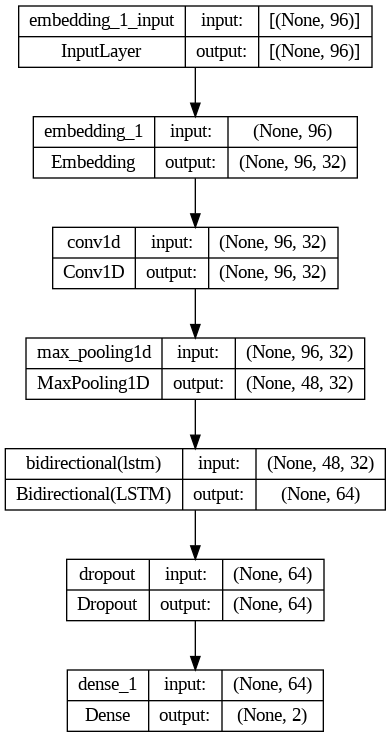

In [49]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [50]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 16
history = model.fit(X_train, y_train,
                      validation_data=(X_test, y_test),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 96, 32)            160000    
                                                                 
 conv1d (Conv1D)             (None, 96, 32)            3104      
                                                                 
 max_pooling1d (MaxPooling1  (None, 48, 32)            0         
 D)                                                              
                                                                 
 bidirectional (Bidirection  (None, 64)                16640     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                

In [51]:
# Evaluate model on the test set
from sklearn.metrics import f1_score

loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))


Accuracy  : 0.8903
Precision : 0.8903
Recall    : 0.8903


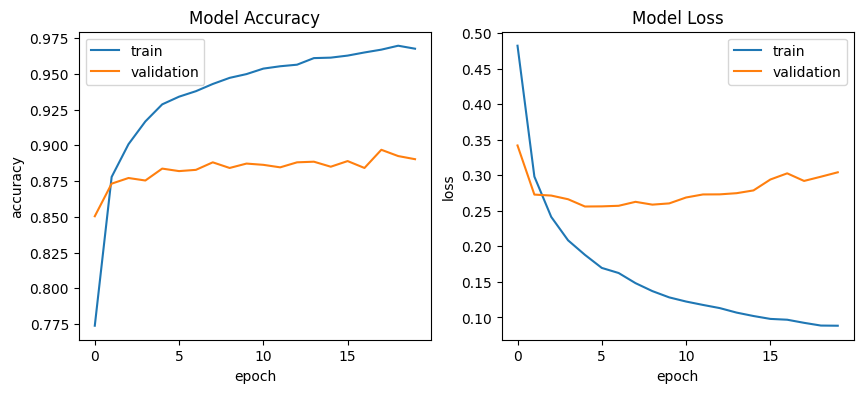

In [52]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

72/72 [==============================] - 1s 4ms/step


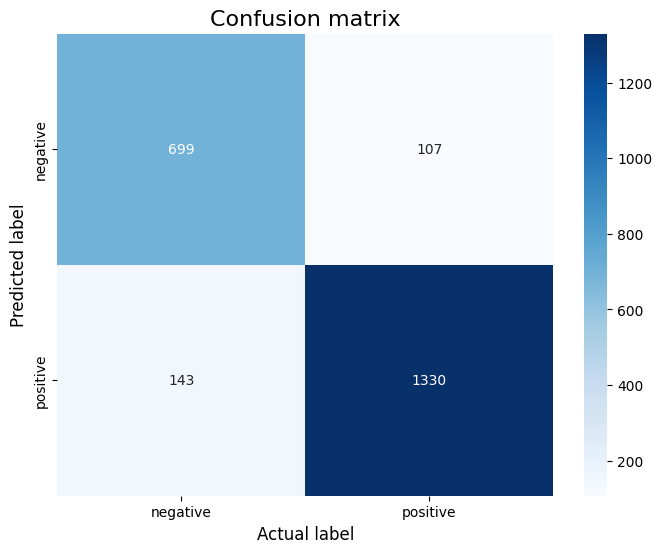

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['negative', 'positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

In [54]:
model.save('best_model.h5')
print('Best model saved')

Best model saved


In [55]:
#prediction
import re
from keras.models import load_model
input_text = '''
tempatnya kotor
'''
sentiment = ['negative','positive']

text = [input_text]
predicted = tokenizer.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=X.shape[1])
print(predicted, guess)
model = load_model('/content/best_model.h5')
prediction= model.predict(guess)
polarity = np.argmax(prediction[0])

print("Text: ", text[0])
print("Sentiment: ", sentiment[polarity])

[[433]] [[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0 433]]
1/1 [==============================] - 1s 708ms/step
Text:  
tempatnya kotor

Sentiment:  positive
